Node2Vec model using torch geometric with Cora

In [7]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1035675 sha256=caa55e9c27863bcc42c1798be332304789e9af3344a9e5d7b38026028ea7dd7b
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Successfully built torch-sparse
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 963.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-cluster: filename=torch_cluster-1.6.3-cp310-cp310-linux_x86_64.whl size=690648 sha256=067d1af1412c48584d9e516e8eed304506ab868b653302aaff57bff80d6bb886
  Stored in directory: /root/.cache/pip/wh

In [18]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

IMPORT DATA

In [19]:
path = "/home/nazanin/Downloads"
dataset = Planetoid(path,"Cora")
data = dataset[0] #tensor representation of the cora-planetoid data
print("Coda: ",data)

Coda:  Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


This means that we have 2708 nodes, each has 1433 features.
We have 10556 edges (connections between the nodes)

CONSTRUCT THE MODEL

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
Node2Vec_model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20, context_size=10, 
                          walks_per_node=10, num_negative_samples=1, p=1, q=1, sparse=True)

num_negative_sample -> We have a graph rep and an embedding rep. We want the nodes close in original rep to be close also in the embedding representation

In roder to train the model with high dimensional data we can do batch training using a loader

In [22]:
loader = Node2Vec_model.loader(batch_size=128, shuffle=True, num_workers=4) # for batch training
#num_workers -> number of cores when we are computing the lower dimension embedding representaion
optimizer = torch.optim.SparseAdam(list(Node2Vec_model.parameters()), #list of parameters
                                   lr=0.01) #learning rate

TRAIN FUNCTION -> TRAIN THE MODEL

In this section we are fitting the data, training the lower dimensional representation

In [25]:
#This is basically fitting the model like NOde2Vec_model.fit(G)
def train():
    Node2Vec_model.train() #set training as true for the model
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad() # reset of gradient of all variables
        loss = Node2Vec_model.loss(pos_rw, neg_rw)
        loss.backward()
        optimizer.step()
        total_loss =+ loss.item()
    return total_loss / len(loader)

# Because we want this to be happening for each of the batches that we have -> 
# We also have to define an epoch that is going to learn for different epoch sizes of samples and learn

GET EMBEDDING

In [26]:
for epoch in range(1,101):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 01, Loss: 0.3084
Epoch: 02, Loss: 0.2494
Epoch: 03, Loss: 0.2045
Epoch: 04, Loss: 0.1712
Epoch: 05, Loss: 0.1482
Epoch: 06, Loss: 0.1229
Epoch: 07, Loss: 0.1069
Epoch: 08, Loss: 0.0951
Epoch: 09, Loss: 0.0844
Epoch: 10, Loss: 0.0761
Epoch: 11, Loss: 0.0672
Epoch: 12, Loss: 0.0616
Epoch: 13, Loss: 0.0584
Epoch: 14, Loss: 0.0540
Epoch: 15, Loss: 0.0521
Epoch: 16, Loss: 0.0491
Epoch: 17, Loss: 0.0475
Epoch: 18, Loss: 0.0462
Epoch: 19, Loss: 0.0454
Epoch: 20, Loss: 0.0434
Epoch: 21, Loss: 0.0431
Epoch: 22, Loss: 0.0424
Epoch: 23, Loss: 0.0411
Epoch: 24, Loss: 0.0413
Epoch: 25, Loss: 0.0409
Epoch: 26, Loss: 0.0410
Epoch: 27, Loss: 0.0401
Epoch: 28, Loss: 0.0402
Epoch: 29, Loss: 0.0401
Epoch: 30, Loss: 0.0399
Epoch: 31, Loss: 0.0392
Epoch: 32, Loss: 0.0393
Epoch: 33, Loss: 0.0391
Epoch: 34, Loss: 0.0386
Epoch: 35, Loss: 0.0394
Epoch: 36, Loss: 0.0386
Epoch: 37, Loss: 0.0386
Epoch: 38, Loss: 0.0382
Epoch: 39, Loss: 0.0391
Epoch: 40, Loss: 0.0385
Epoch: 41, Loss: 0.0375
Epoch: 42, Loss:

PLOT 2D OF EMBEDDED REP

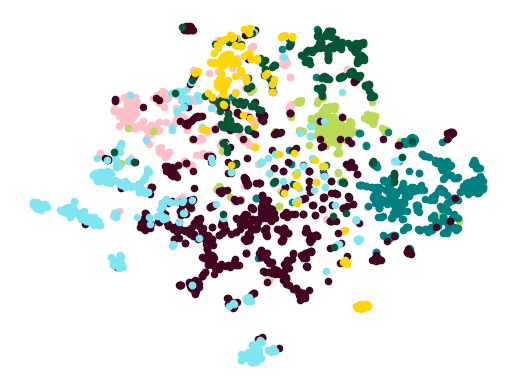

In [27]:
@torch.no_grad() # Deactivate autograd functionality
def plot_point(colors):
    #here the model is already trained so we can use it to plot
    Node2Vec_model.eval() # Evaluate the model based on the trained parameters
    z = Node2Vec_model(torch.arange(data.num_nodes, device=device)) #embedding rep
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()
    plt.figure()
    for i in range(dataset.num_classes):
        plt.scatter(z[y==i,0],z[y==i,1],s=20,color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_point(colors)

    


NODE CLASSIFICATION

Previously we did this by using LinearRegression and splitting test and train data but Node2Vec model already has a test function implemented

In [28]:
def test():
    Node2Vec_model.eval() # Evaluate models based on trained parameters
    z = Node2Vec_model()
    acc = Node2Vec_model.test(z[data.train_mask], data.y[data.train_mask], 
                              z[data.test_mask], data.y[data.test_mask],
                              max_iter=150)
    return acc

print('Final accuaracy: ',test())

Final accuaracy:  0.705
